<h1 style="text-align: center; color: purple;" markdown="1">Red Ventures Take-home Exercise</h1>


<h3 style="text-align: center; color: #012169" markdown="1"> Author: Letao (Julietta) Zhu </h3>

# Big Picture 
### EDA
* Before I delve into the analysis and answer the listed question, I want to first calculate the current revenue and approval rate, creating some plots to better understand the dataset.


### Match-making Analysis
* For the first question, my first thought is to treat this as a predictive exercise. Start by building a binary classifier for approval (in general) to determine what predictors matter for determining approval.  Then build separate models for approval by A, B, and C to see if the same variables seem to matter. Use random forest with feature importance.

* Part two explores what differs between lenders.  Combine the feature importances analysis to determine if there are differences in who gets approved at the different lenders.

* Use separate models to predict a probability of approval for each lender for a held out test set. Then, multiply this by the revenue for each accepted loan to get an expected revenue for each customer and recommend the lender that yields the highest expected revenue.  Compare this expected revenue over the set of held out customers (test data) for the "best revenue" model to current pairing. 


### Comparisons and Outcomes
* I will compare the predicted revenue with Bankrate's current revenue. Hopefully the very last step of the analysis will generate a higher predicted revenue than the current one, meaning that with a better pairing model, our client can make more money. 


In [10]:
import sys
sys.executable

'/workspaces/Bankrate/.venv/bin/python'

### Table of Contents 
* [EDA](#anchor1) 
* [Match-making Analysis](#anchor2) 
* [Comparisons and Outcomes](#anchor3) 


In [9]:
#import libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn .ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
%matplotlib inline
sns.set(style="whitegrid")

In [3]:
data_dir = Path("../data")
df = pd.read_excel(data_dir/"loan_data.xlsx")

## EDA <a class="anchor" id="anchor1"></a>

In [4]:
df['User ID'].nunique() # There are 100,000 distinct customers

100000

In [5]:
# check for missing

df.isnull().sum()

# we will take out Employment_Sector due to missing values

User ID                          0
applications                     0
Reason                           0
Loan_Amount                      0
FICO_score                       0
Fico_Score_group                 0
Employment_Status                0
Employment_Sector             6407
Monthly_Gross_Income             0
Monthly_Housing_Payment          0
Ever_Bankrupt_or_Foreclose       0
Lender                           0
Approved                         0
bounty                           0
dtype: int64

In [6]:
# current revenue = sum(fee * number of approval)

approval_count = df[df['Approved'] == 1].groupby('Lender').agg(
    Count_Approved=('Approved', 'count'))

current_revenue = 250*approval_count.iloc[0] + 350*approval_count.iloc[1] + 150*approval_count.iloc[2] 

# Convert the Series to a scalar value for formatting
current_revenue_scalar = current_revenue.iloc[0]

# Format and print the current revenue with commas
print(f"The current revenue is: {current_revenue_scalar:,.0f}")

approval_count

The current revenue is: 2,641,500


,Count_Approved
Lender,
A,6031
B,1960
C,2985


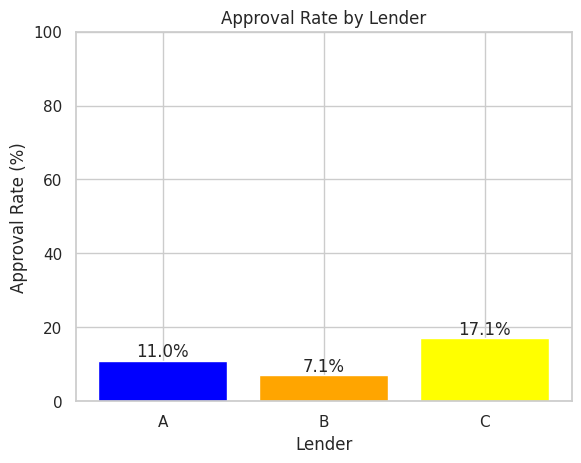

In [7]:
#### approval rate = count_approved/total_application ####

# total number of applications for each lender
total_applications = df.groupby('Lender')['Approved'].count()

# approval rate for each lender
approval_rate = approval_count['Count_Approved'] / total_applications * 100




#### Plotting ########
fig, ax = plt.subplots()
bars = plt.bar(approval_rate.index, approval_rate, color=['blue', 'orange', 'yellow'])

# Label each bar with its exact percentage value
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%', ha='center', va='bottom')

# Set y-axis scale to be from 0 to 100
ax.set_ylim(0, 100)

plt.xlabel('Lender')
plt.ylabel('Approval Rate (%)')
plt.title('Approval Rate by Lender')
plt.show()


## Match-making Analysis <a class="anchor" id="anchor2"></a>


### Step 1: Prepare the data
* Determine useful variables 
* Construct new variables 
* Transform categorical variables into dummies for training the model

In [8]:
# consturct housing ratio and loan_income_ratio as new features(a form of debt to earning ratio)
df['housing_ratio'] = df['Monthly_Housing_Payment'] / df['Monthly_Gross_Income']
df['loan_income_ratio'] = df['Loan_Amount']/df['Monthly_Gross_Income']

In [9]:
# dummy out categorical variables
df = pd.get_dummies(df, columns=['Reason','Fico_Score_group','Employment_Status'], drop_first=True)

### Step 2: A random forest classifier predicting approval of all three lenders 

In [10]:
# create a feature dataset (X) and the dependent variable (y = 'Approved')
# drop Employment_Sector due to missing value
# drop bounty - the commission fee - irrelavant
# housing_payment, loan amount - look housing payment,loan with respect to revenue 
# approved - dependent variable
X = df.drop(['User ID','Lender','Employment_Sector','bounty','Monthly_Housing_Payment','Approved','Loan_Amount'], axis = 1)
y = df['Approved']


# split the data into training and testing sets
# why test: evaluate the performance of a ml model on unseen data, prevent overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Train the random forest model

rf_model = RandomForestClassifier(n_estimators=100, random_state=42) # create a rf classifier with 100 decision trees; 42 for reproducibility
rf_model.fit(X_train, y_train) #train it on X_train and Y_train

# determine the accuracy of the model
y_test_pred = rf_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred) #correct/#total

print("Accuracy on the test Set:", accuracy_test)



Accuracy on the test Set: 0.8901


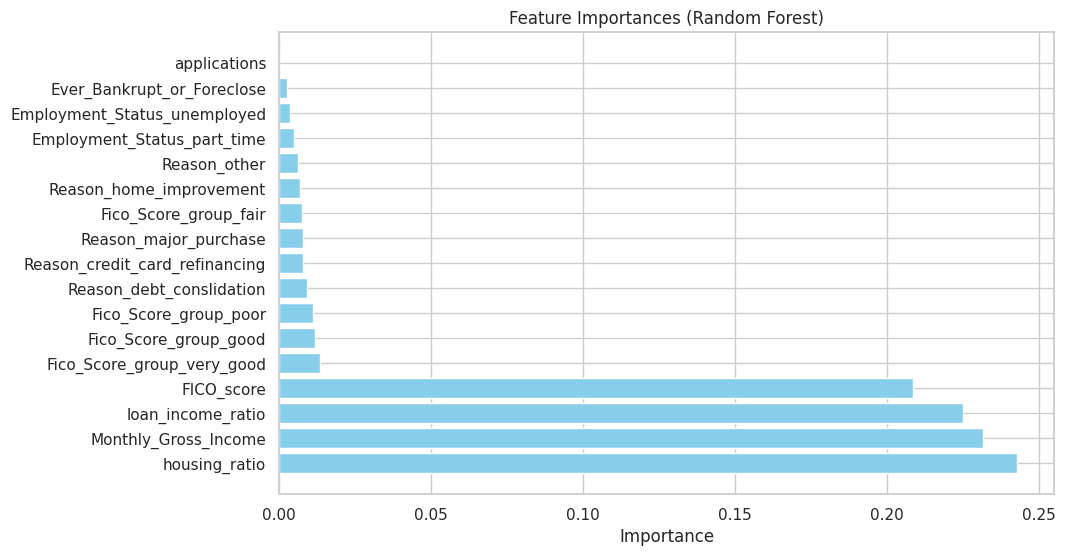

In [12]:
# Get feature importances
feature_importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort by importances in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances (Random Forest)')
plt.show()

In general across three lenders, we see that housing payment to income ratio, monthly gross income, Fico score, and loan to income ratio matter the most for determining approval.

In the following, I  will look at the feature importance for each lender and see if there's any differences among them.

### Step 3: Build 3 separate rf classifier for approval by A, B, C

* have one rf model looking at approval pattern of each lender
* observe whether the same variables/features seem to matter

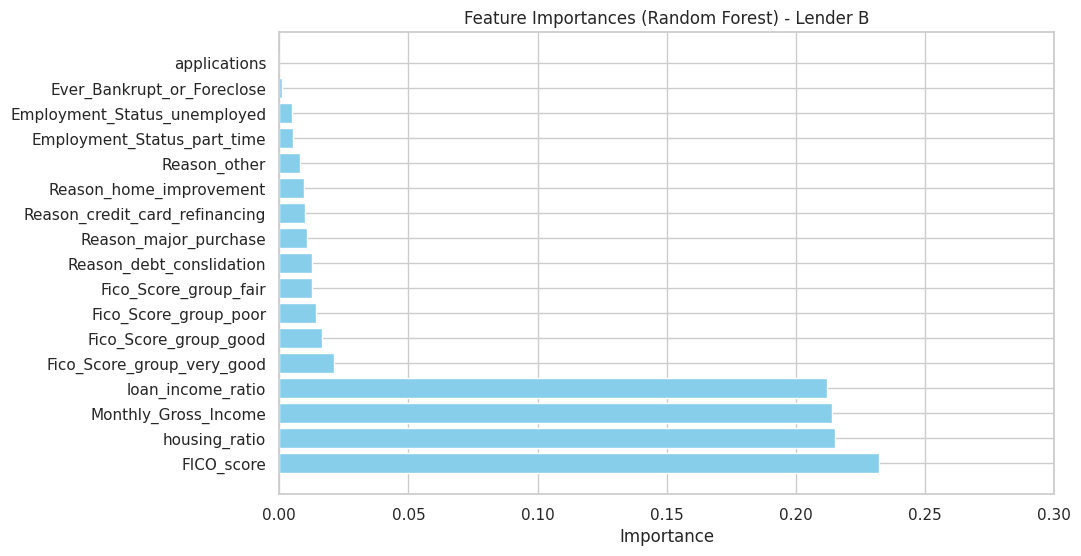

Accuracy for Lender B: 0.90945


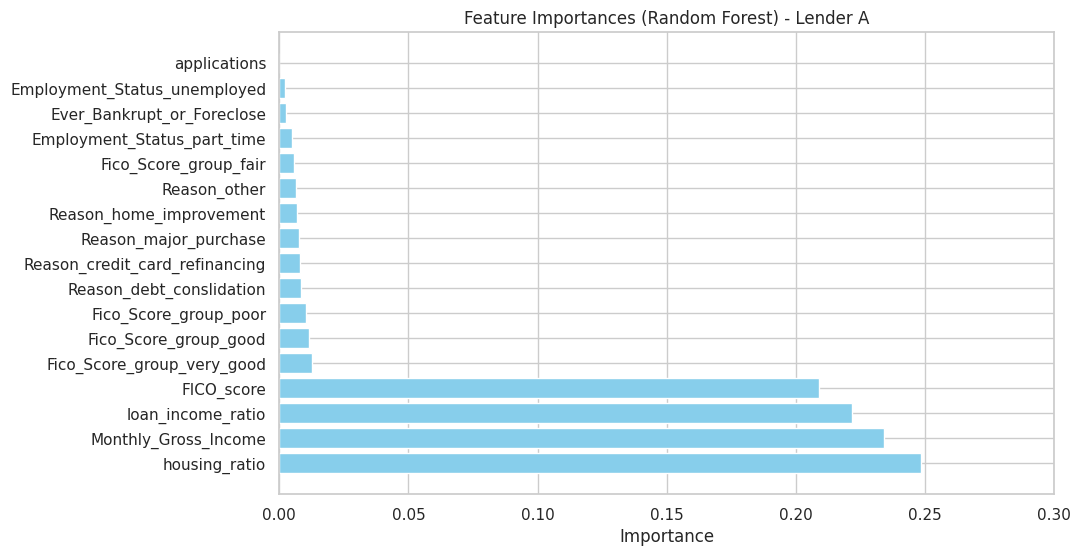

Accuracy for Lender A: 0.9451


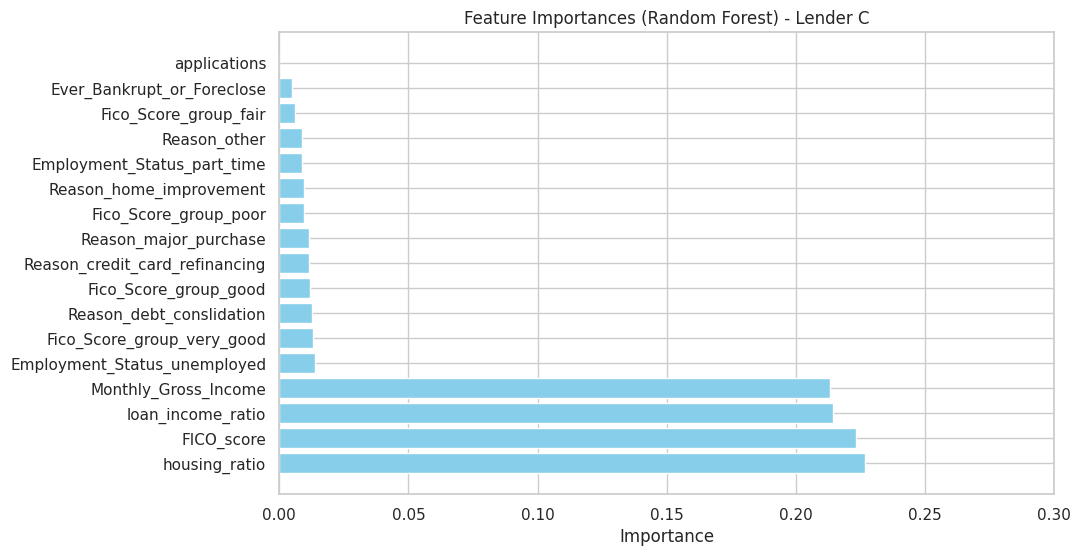

Accuracy for Lender C: 0.90255


In [13]:
### feature importances segmented by lender ###

# lenders = A, B, C
lenders = df['Lender'].unique()

# Set a common xlim for all plots
common_xlim = (0, 0.3)

# Loop over each lender and a build randomforest classifier for each
for lender in lenders:
    # Subset the data for the current lender
    lender_data = df[df['Lender'] == lender]

    # Create feature dataset (X) and target variable (y) for the current lender
    X_lender = lender_data.drop(['User ID','Lender','Employment_Sector', 'bounty', 'Monthly_Housing_Payment', 'Approved','Loan_Amount'], axis=1)
    y_lender = lender_data['Approved'] 
    
    # Train the random forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42) #100 trees 
    rf_model.fit(X_lender, y_lender) #train it on X and Y

    # Get feature importances
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame with feature names and importances
    feature_importance_df = pd.DataFrame({'Feature': X_lender.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importances in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plotting for the current lender
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title(f'Feature Importances (Random Forest) - Lender {lender}')
    plt.xlim(common_xlim)
    plt.show()
    
    # Predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Accuracy on the test set
    accuracy = accuracy_score(y_test, y_pred)

    # Print or use the accuracy as needed
    print(f'Accuracy for Lender {lender}: {accuracy}')


As you can see, FICO score, housing payment to income ratio, monthly revenue, as well as loan to income ratio remain the most important factors for all three lenders. there are slight differences in terms of the lender's priority. For example, lender B relies the most on FICO score whereas A and C rely on housing ratio. 

**Note: the way we interpret feature importances is to look at the order of the features within groups. It is meaningless to, let's say, compare the importance of FICO score for lender A and B. We can only say Fico score is important relative to other features for both A and B.  

With the feature importances plots, it makes sense for me to look at some descriptive statistics of the top four features across three lenders.


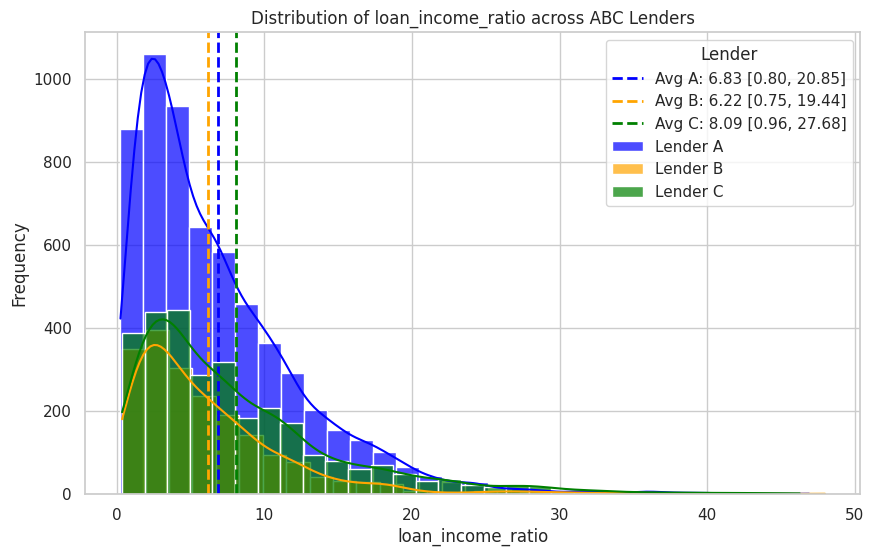

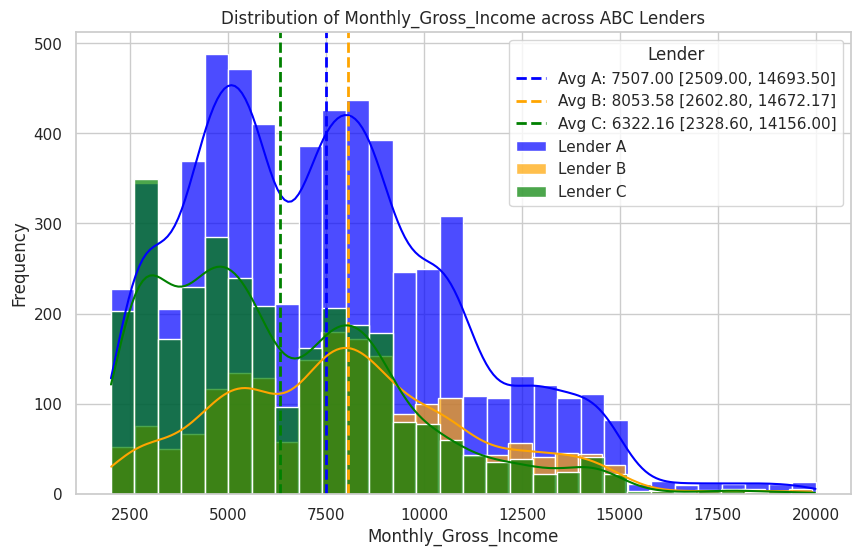

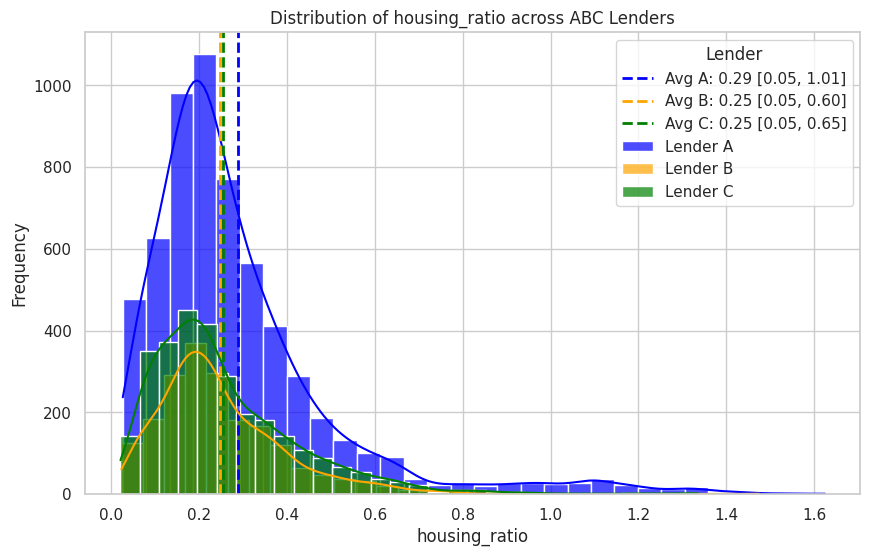

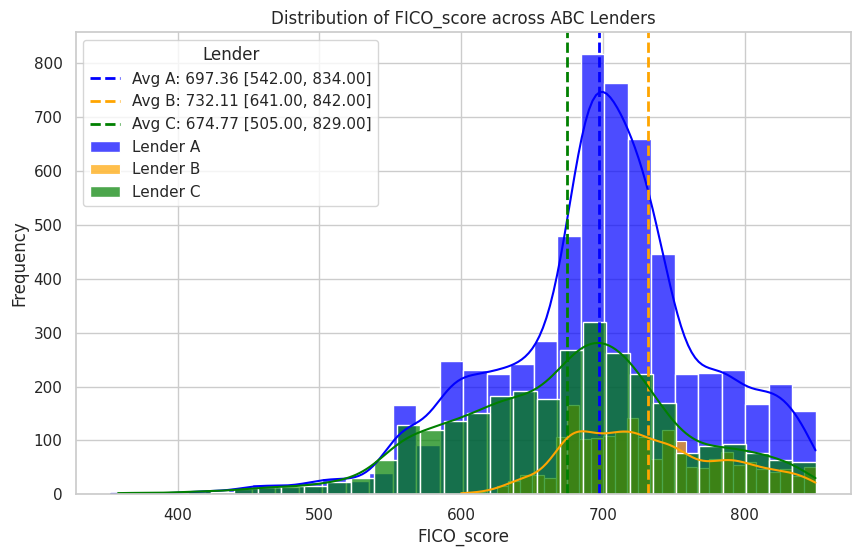

In [14]:
top_features = ['loan_income_ratio', 'Monthly_Gross_Income', 'housing_ratio', 'FICO_score']

lender_colors = {'A': 'blue', 'B': 'orange', 'C': 'green'} #create 3 colors for plots


for feature in top_features:
    # Create a histogram for each feature
    plt.figure(figsize=(10, 6))
    for lender, color in lender_colors.items():
        df_approved = df[df['Approved']==1] #only look at approved cases
        lender_data = df_approved[df_approved['Lender'] == lender] # split the data by lenders
        sns.histplot(data=lender_data, x=feature, kde=True, bins=30, color=color, alpha=0.7, label=f'Lender {lender}') #30 bins
        
        # Calculate and display the average value
        average_value = lender_data[feature].mean()
        
        # Calculate the 95% confidence interval
        ci_low, ci_high = sns.utils.ci(lender_data[feature]) #default is 95% - 95% confident that the true parameter lies within the range
        
        # Display the average value with confidence interval
        plt.axvline(average_value, color=color, linestyle='dashed', linewidth=2, label=f'Avg {lender}: {average_value:.2f} [{ci_low:.2f}, {ci_high:.2f}]')

    plt.title(f'Distribution of {feature} across ABC Lenders')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Lender')
    plt.show()



There isn't any statistically significant differences in top 4 features across lender. Hence, relying on models to automatically detect and capture differences in the data may provide a more comprehensive and nuanced understanding of complex relationships. 

In the following, I will train separate models to predict the probability of approval for each lender for a held-out test set and calculate the expected revenue if a consumer goes to one of the three lenders. By comparing the expected revenue, we can identify which lender has the highest approval rate given her specific characteristics, allowing for more informed and optimized lender recommendations.

**Future analysis**: One thing I notice from the confidence interval is that there's a high level of variability in these top features across the sample - it's worth considering outliers or segment the data to understand the approval pattern of each sub-group.

### Step 4: Compare this expected revenue over the set of held out customers (test data) for the "best revenue" model to current pairing. 

* split the data into train and test set - use the training set to train random forest classifier predictiing approval of lender A, B, C separately
* assigning a possibility of approval by A, B, C to each user in the test set
* calculate the expected revenue by multiplying possibility of approval by each lender * the corresponding bounty earned
* assign each customer in the test set to the lender that generate the highest expected value


In [15]:
####### manually split data into train and test sets #################

# Calculate the number of rows for each part
total_rows = len(df)
rows_80_percent = int(0.8 * total_rows)

#split df 80/20 manually for train and test set
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle the DataFrame before split by rows
df_train = df_shuffled.iloc[:rows_80_percent, :]
df_test= df_shuffled.iloc[rows_80_percent:, :]


############# training set by lenders ################

# Get unique lenders from the 'Lender' column
lenders = df['Lender'].unique()

df_train_by_lender = {lender: df_train[df_train['Lender'] == lender] for lender in lenders}

# Access each DataFrame by lender name
df_a = df_train_by_lender['A']
df_b = df_train_by_lender['B']
df_c = df_train_by_lender['C']

# creat X and y for each lender - train 3 different models
X_a = df_a.drop(['User ID','Lender','Employment_Sector','bounty','Monthly_Housing_Payment','Approved','Loan_Amount', ], axis = 1)
y_a = df_a['Approved']

X_b = df_b.drop(['User ID','Lender','Employment_Sector','bounty','Monthly_Housing_Payment','Approved','Loan_Amount'], axis = 1)
y_b = df_b['Approved']

X_c = df_c.drop(['User ID','Lender','Employment_Sector','bounty','Monthly_Housing_Payment','Approved','Loan_Amount'], axis = 1)
y_c = df_c['Approved']

##### Train the random forest model ######
rf_model_a = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_a.fit(X_a, y_a)

rf_model_b = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_b.fit(X_b, y_b)

rf_model_c = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_c.fit(X_c, y_c)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

Now that we have the models, let's predict the expected revenue for the group of customers that we took out earlier.

In [16]:
X_test = df_test.drop(['User ID','Lender','Employment_Sector','bounty','Monthly_Housing_Payment','Approved','Loan_Amount'], axis = 1)
y_test = df_test['Approved']

# The predict_proba method returns the predicted probabilities for each class, 
# [:, 1] is used to select the probabilities corresponding to class 1.
prob_a = rf_model_a.predict_proba(X_test)[:, 1] # the possibility that A approves
prob_b = rf_model_b.predict_proba(X_test)[:, 1] # the possibility that B approves
prob_c = rf_model_c.predict_proba(X_test)[:, 1] # the possibility that C approves

# Revenue from making a loan from lenders
revenue_a = 250  
revenue_b = 350
revenue_c = 150

# Calculate expected revenue for each lender
expected_revenue_a = prob_a * revenue_a
expected_revenue_b = prob_b * revenue_b
expected_revenue_c = prob_c * revenue_c

# Determine the recommended lender for each customer
best_lender = np.argmax(np.column_stack((expected_revenue_a, expected_revenue_b, expected_revenue_c)), axis=1) # get a series of index respresenting lender that generate the best ER
# Mapping function
lender_mapping = {0: 'A', 1: 'B', 2: 'C'} # map the index to the corresponing lender

# a list of best revenue lender
recommended_lender = np.vectorize(lambda x: lender_mapping[x])(best_lender) #apply the mapping element by element in the best lender

# Calculate expected revenue for the "best revenue" lender
expected_revenue_best = np.max(np.column_stack((expected_revenue_a, expected_revenue_b, expected_revenue_c)), axis=1)



## Comparisons and Outcomes <a class="anchor" id="anchor3"></a> 

* Using the held out test set, comparing the given revenue under current pairing with the predicted revenue under the new pairing 
* Calculate the percentage change
* Apply the percentage change to the current total revenue to estimate the new revenue


In [ ]:
# Compare the revenue for the "best revenue" model to the other scenarios
comparison_df = pd.DataFrame({
    'Expected_Revenue_Best': expected_revenue_best,
    'Recommended_Lender': recommended_lender,
    'Expected_Revenue_Recommend_A': expected_revenue_a,
    'Probability_of_approval_A': prob_a,
    'Expected_Revenue_Recommend_B': expected_revenue_b,
    'Probability_of_approval_B': prob_b,
    'Expected_Revenue_Recommend_C': expected_revenue_c,
    'Probability_of_approval_C': prob_c})
    

# Print or analyze the comparison_df as needed
# comparison_df.to_excel(data_dir/'comparison_df.xlsx', index=False)
comparison_df.head()

,Expected_Revenue_Best,Recommended_Lender,Expected_Revenue_Recommend_A,Probability_of_approval_A,Expected_Revenue_Recommend_B,Probability_of_approval_B,Expected_Revenue_Recommend_C,Probability_of_approval_C
0,32.5,A,32.5,0.13,7.0,0.02,6.0,0.04
1,25.0,A,25.0,0.10,0.0,0.00,18.0,0.12
2,28.0,B,5.0,0.02,28.0,0.08,22.5,0.15
3,19.5,C,10.0,0.04,0.0,0.00,19.5,0.13
4,52.5,A,52.5,0.21,14.0,0.04,40.5,0.27


In [18]:
# total for the test dataset using the rf model
totals = comparison_df['Expected_Revenue_Best'].sum()


# current total for the test dataset
df_test[df_test['Approved'] == 1].groupby('Lender').agg(
    Count_Approved=('Approved', 'count'))

current_totals = 1235*250 + 390*350 + 629*150

# percentage increase
percentage_increase = (totals - current_totals)/current_totals
print(f"The percentage revenue growth will potentially be around {percentage_increase:,.2f}")



# predicted revenue
predicted_revenue = (1+percentage_increase)*current_revenue
predicted_revenue_scalar = predicted_revenue.iloc[0]
print(f"The predicted revenue with the new matching model is: {predicted_revenue_scalar:,.0f}")


The percentage revenue growth will potentially be around 0.70
The predicted revenue with the new matching model is: 4,483,836
